# Semantic Segmentation through Deep Learning
## Presented by Shaul & Sasha:

### we will be using PYTORCH - https://github.com/pytorch/pytorch
### and a library called SEGMENTATION_MODELS - https://github.com/qubvel/segmentation_models.pytorch#examples

### the code is based on the example withing segmentation_models github page

# Loading Data
consists of the subfolders within the data folder:

1. train images + train masks
2. validation images + validation masks
3. test images + test masks


##### Import the libraries we will need to use

In [1]:
# imports
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

##### are we training or predicting ?

In [2]:
TRAINING = 0  # set True or False

##### set the paths for our model file, training and validation data

In [3]:
# relevant paths for training

# path for model file
# if model already exists in the path, the training will continue from the saved model
# else a new model will be trained from scratch
model_pth = r'deeplab_imagenet_model.pth'

# paths for training data
TRAIN_DIR = r'train'
VALUA_DIR = r'eval'
TEST_DIR = r'test'

x_train_dir = os.path.join(TRAIN_DIR, 'image')
y_train_dir = os.path.join(TRAIN_DIR, 'mask')

x_valid_dir = os.path.join(VALUA_DIR, 'image')
y_valid_dir = os.path.join(VALUA_DIR, 'mask')

# define test dirs
x_test_dir = os.path.join(TEST_DIR, 'image')
y_test_dir = os.path.join(TEST_DIR, 'mask')

##### set training parameters - number of epochs, learning rate, etc ...

In [4]:
EPOCHS = 50
LR = 0.0001
IOU = 0.5

# MAX_SCORE:
#          the model will be saved only
#          if the result IoU score is better then the current score
# MIN_SCORE:
#          the model will be saved only if
#          the IoU score in bigger then this value    
# ALL:
#           the model will be saved no matter the score

MAX_SCORE = True
MIN_SCORE = None
ALL = None

# the class information - in this case we want to predict only one class
_CLASSES_ = ['255']  # this should match the dataset class

# MODEL HYPER-PARAMETERS #
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'  # 'imagenet'
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### training, validation, image tile shapes and preprocessing methods

In [5]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=90, shift_limit=0.2, p=1, border_mode=2),
        albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.5),
        albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    # make sure the height and width of image tiles is set correctly
    val_transform = [albu.RandomCrop(height=1024, width=1024, always_apply=True), albu.PadIfNeeded(1024, 1024)]
    return albu.Compose(val_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """
    Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
        (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [albu.Lambda(image=preprocessing_fn), albu.Lambda(image=to_tensor, mask=to_tensor)]
    return albu.Compose(_transform)

#####

In [6]:
class Dataset(BaseDataset):
    """
    Custom dataset created by shaul & sasha. Read images, apply augmentation and preprocessing transformations
    Args:
        images_dir (str)   : path to images folder
        masks_dir  (str)   : path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose) : data transfromation pipeline 
        (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
        (e.g. noralization, shape manipulation, etc.)
    """

    CLASSES = _CLASSES_

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        
        img_list = os.listdir(images_dir)
        msk_list = os.listdir(masks_dir)
        img_path_list = []
        msk_path_list = []
        # make sure the lists are syncronized
        # dont include imgs that have empty or no msk
        # only img msk pairs will enter the training set

        img_list = [img for img in img_list if img in msk_list]
        for msk_name in msk_list:
            img_path_list.append(images_dir + "\\" + msk_name)
            msk_path_list.append(masks_dir + "\\" + msk_name)

        if len(img_path_list) == len(msk_path_list):
            print(f'[info] reading from {images_dir}')
            print(f'[info] img: {len(img_path_list)} msk:{len(msk_path_list)}')
        else:
            print('[error] img-msk pair dont match')
            print(f'[info] img: {len(img_path_list)} msk:{len(msk_path_list)}')
            sys.exit()

        self.images_fps = img_path_list
        self.masks_fps = msk_path_list

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        # self.class_values = [1]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        try:
            image = cv2.imread(self.images_fps[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print('[error with image file] ', self.images_fps[i])

        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            try:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            except:
                print('[!err! - preprocessing] ', sample['image'], sample['mask'])
        return image, mask

    def get_name(self, i):
        return os.path.basename(self.images_fps[i])

    def __len__(self):
        return len(self.images_fps)

##### Choosing architecture hyper-parameters and creating a model

In [7]:

try:
    model = torch.load(model_pth)
    
except:
    print('[info] running new model from scratch ...')
    # model = smp.FPN(
    #     encoder_name=ENCODER, 
    #     encoder_weights=ENCODER_WEIGHTS, 
    #     classes=len(_CLASSES_), 
    #     activation=ACTIVATION, 
    # )
    
    model = smp.DeepLabV3Plus(
        # encoder_name=ENCODER,  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=ENCODER_WEIGHTS,  # use `imagenet` pretreined weights for encoder initialization
        in_channels=3,  # model input channels (1 for grayscale images, 3 for RGB, etc.)
        classes=len(_CLASSES_),# model output channels (number of classes in your dataset)
        activation=ACTIVATION, # activation function
    )

    
"""
Unet
Linknet
FPN
PSPNet
PAN
DeepLabV3 and DeepLabV3+
"""

[info] running new model from scratch ...


'\nUnet\nLinknet\nFPN\nPSPNet\nPAN\nDeepLabV3 and DeepLabV3+\n'

##### Creating Dataset + Loader objects for training and validation datasets

In [8]:
preprocessing_fn = None  # or use if necessary - smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=_CLASSES_,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=_CLASSES_,
)

# increase batch_size if working with high-end GPU
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

[info] reading from train\image
[info] img: 242 msk:242
[info] reading from eval\image
[info] img: 60 msk:60


##### Setting loss function, metrics for model effectivness and optimizer

In [9]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=IOU)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=LR)])

# Training Our Model

##### Creating epoch runners (simple loop that runs over DataLoader's items

In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

##### Training loop 

In [11]:
max_score = 0
##########
epochs = EPOCHS
##########
train_logs_list, valid_logs_list = [], []


if TRAINING:
    print('[inf] ... ... ... training ... ... ...')
    for i in range(1, epochs + 1):
        print('[results] \nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        print('[results] IOU score', valid_logs['iou_score'])

        if MAX_SCORE and (max_score < valid_logs['iou_score']):
            max_score = valid_logs['iou_score']
            torch.save(model, model_pth)
            print(f'[results] Model saved! from max-score of: {max_score}')
        elif MIN_SCORE:
            max_score = valid_logs['iou_score']
            if (max_score > MIN_SCORE):
                torch.save(model, model_pth)
                print(f'[results] Model saved! from min-score of:{MIN_SCORE}')
        elif ALL:
            torch.save(model, model_pth)
            print('[results] Model saved! from All')

[inf] ... ... ... training ... ... ...
[results] 
Epoch: 1
valid: 100%|███████████████████████████████████| 60/60 [00:04<00:00, 14.21it/s, dice_loss - 0.1355, iou_score - 0.8468]
[results] IOU score 0.8468175465861956
[results] Model saved! from max-score of: 0.8468175465861956
[results] 
Epoch: 2
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 13.92it/s, dice_loss - 0.06605, iou_score - 0.9172]
[results] IOU score 0.9172391970952354
[results] Model saved! from max-score of: 0.9172391970952354
[results] 
Epoch: 3
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 13.35it/s, dice_loss - 0.05822, iou_score - 0.9177]
[results] IOU score 0.9176961531241735
[results] Model saved! from max-score of: 0.9176961531241735
[results] 
Epoch: 4
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 14.66it/s, dice_loss - 0.06878, iou_score - 0.9073]
[results] IOU score 0.9073082764943443
[results] 
Epoch: 5
valid: 100%|██████████████████████████████

valid: 100%|███████████████████████████████████| 60/60 [00:04<00:00, 12.49it/s, dice_loss - 0.02996, iou_score - 0.945]
[results] IOU score 0.9450043270985286
[results] Model saved! from max-score of: 0.9450043270985286
[results] 
Epoch: 26
valid: 100%|███████████████████████████████████| 60/60 [00:04<00:00, 14.65it/s, dice_loss - 0.0305, iou_score - 0.9441]
[results] IOU score 0.9440644919872286
[results] 
Epoch: 27
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 14.73it/s, dice_loss - 0.02833, iou_score - 0.9476]
[results] IOU score 0.9476150681575138
[results] Model saved! from max-score of: 0.9476150681575138
[results] 
Epoch: 28
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 14.43it/s, dice_loss - 0.02968, iou_score - 0.9452]
[results] IOU score 0.9452199111382169
[results] 
Epoch: 29
valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 14.26it/s, dice_loss - 0.02942, iou_score - 0.9454]
[results] IOU score 0.9453758319218953

valid: 100%|██████████████████████████████████| 60/60 [00:04<00:00, 14.02it/s, dice_loss - 0.02488, iou_score - 0.9531]
[results] IOU score 0.9530505528052647
[results] Model saved! from max-score of: 0.9530505528052647


#### Visualize train and valid logs as graphs

In [12]:
np.savetxt("deeplab_imagenet_50epochs_valid.csv", valid_logs_list, delimiter=",", fmt='%s')
np.savetxt("deeplab_imagenet_50epochs_train.csv", train_logs_list, delimiter=",", fmt='%s')

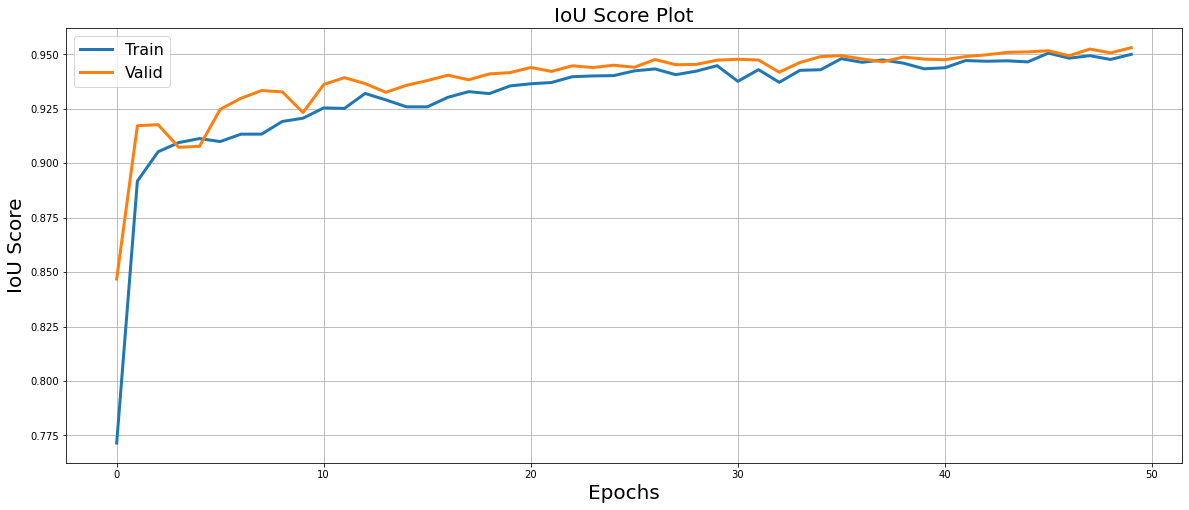

In [13]:
import pandas as pd

train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

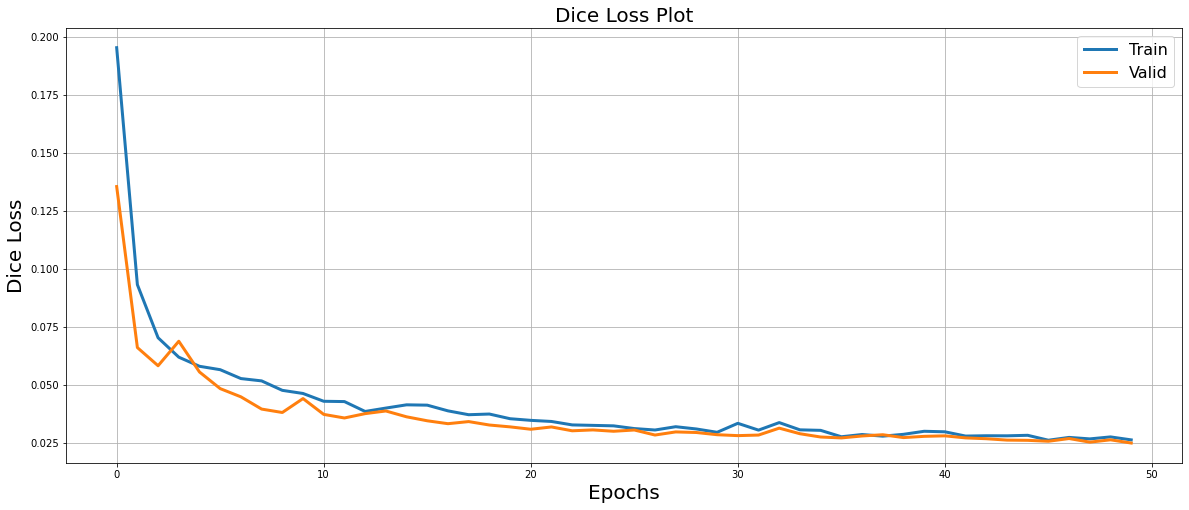

In [14]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()



# Predicting Semantic Segmentation of Buildings

In [15]:
# helper function for data visualization
def visualize(**images):
    """plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [16]:
# load best saved checkpoint
best_model = torch.load(model_pth)

In [17]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=_CLASSES_,
)

test_dataloader = DataLoader(test_dataset)

[info] reading from test\image
[info] img: 19 msk:19


In [18]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████████████████████████████| 19/19 [00:01<00:00, 13.22it/s, dice_loss - 0.03385, iou_score - 0.9354]


In [19]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=_CLASSES_,
)

[info] reading from test\image
[info] img: 19 msk:19


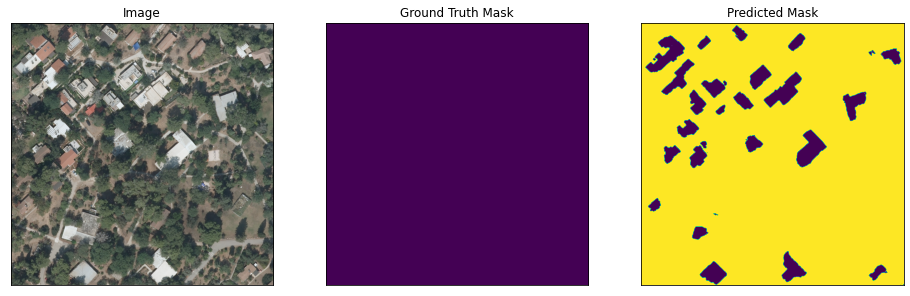

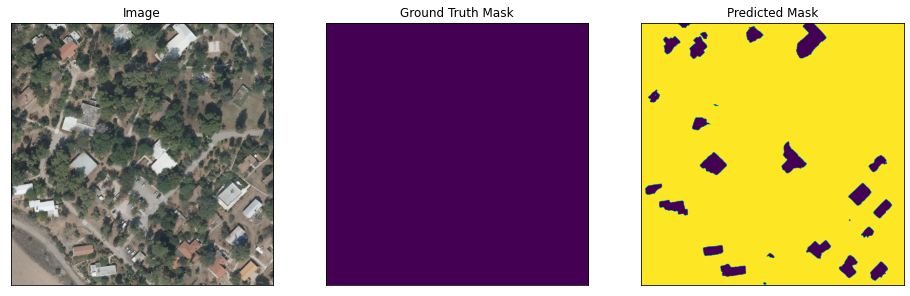

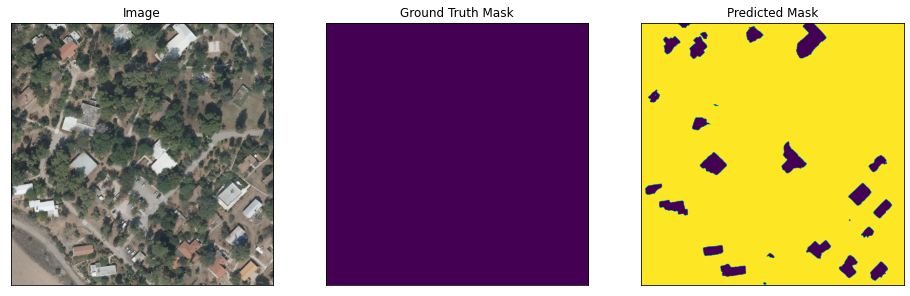

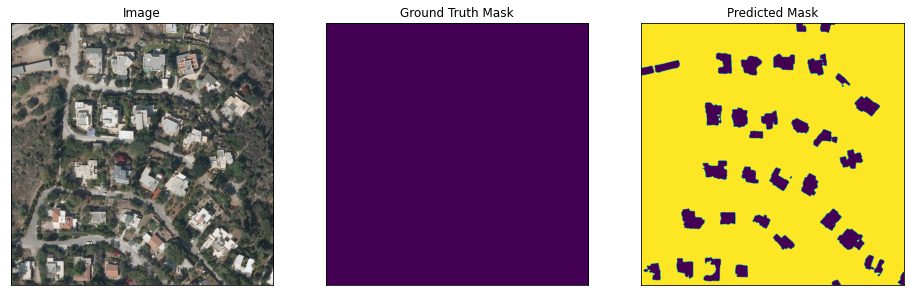

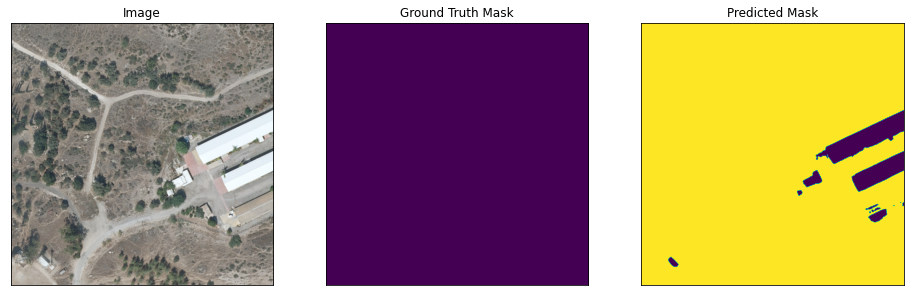

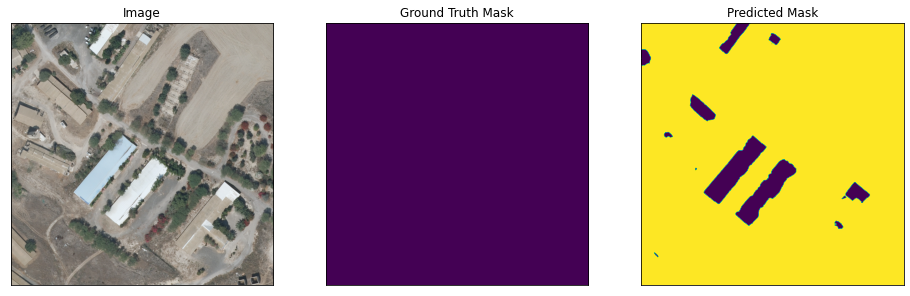

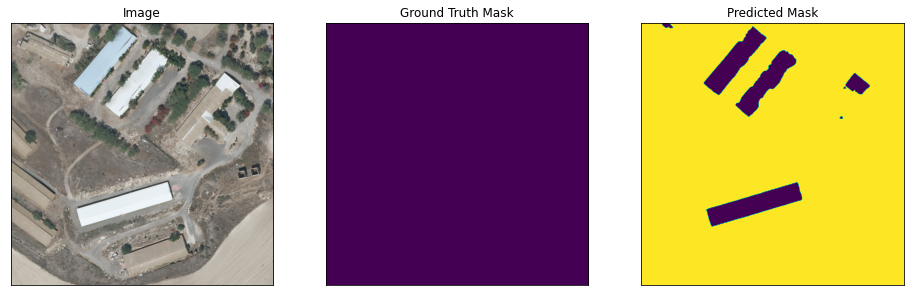

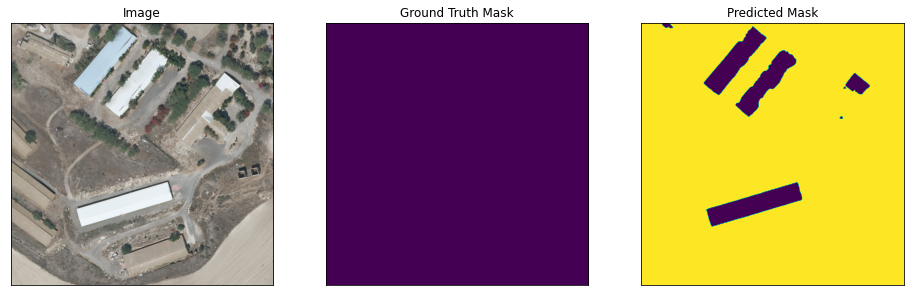

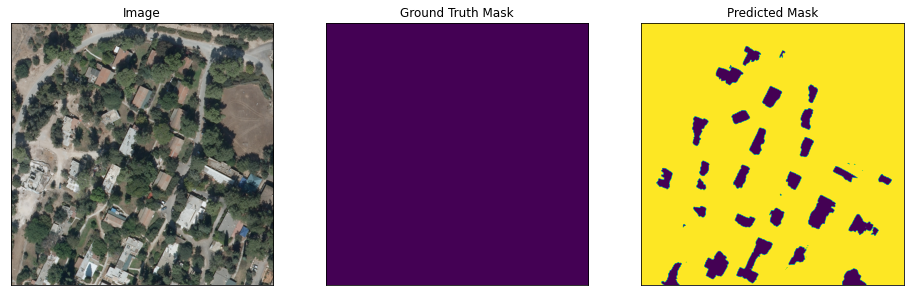

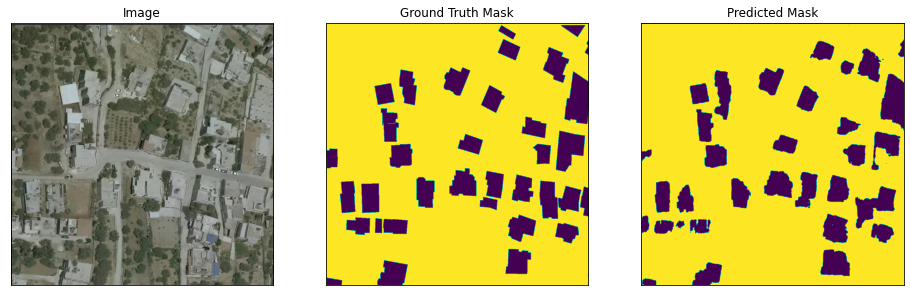

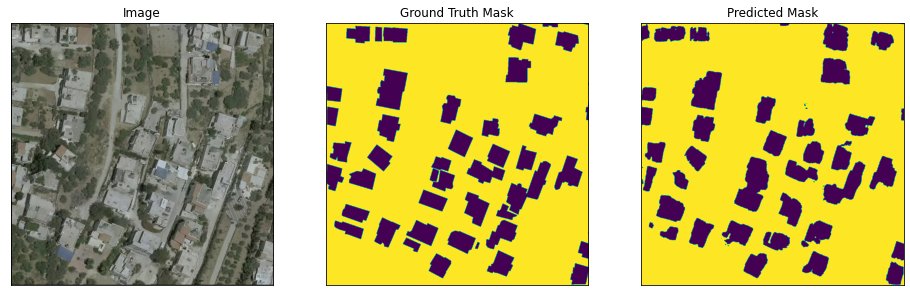

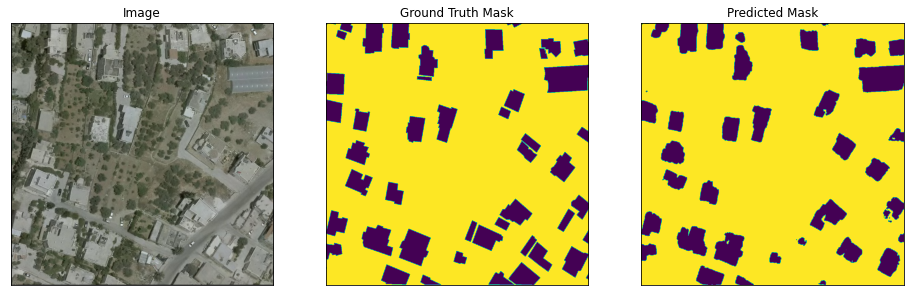

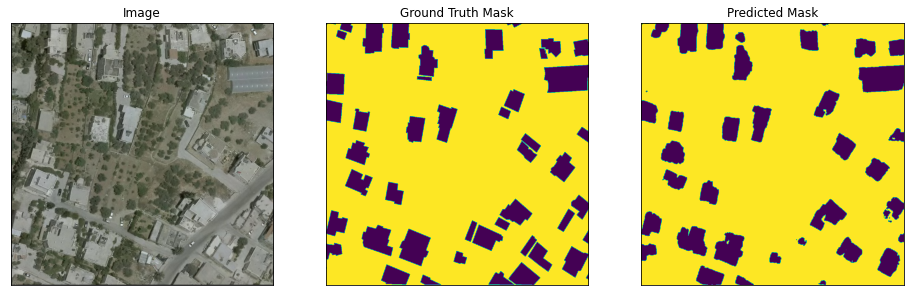

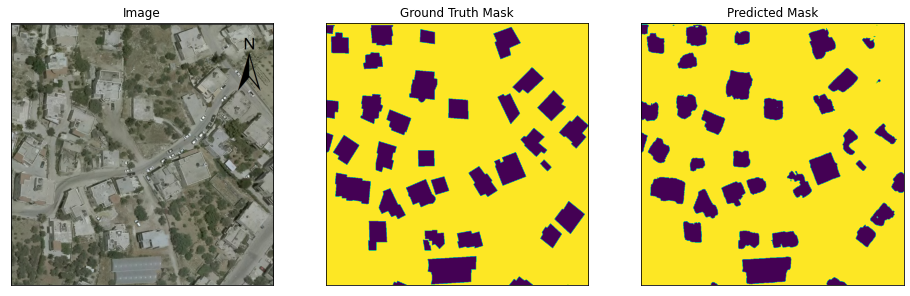

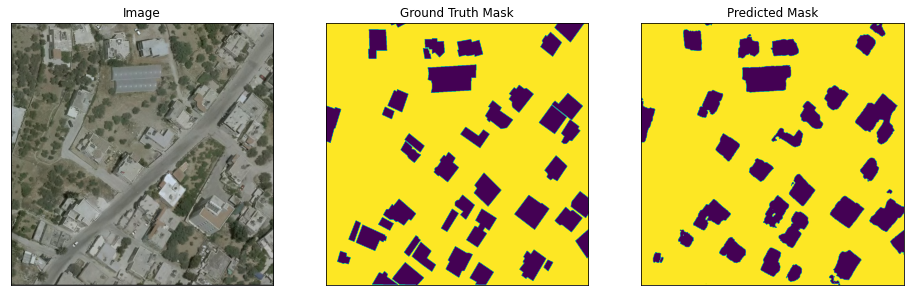

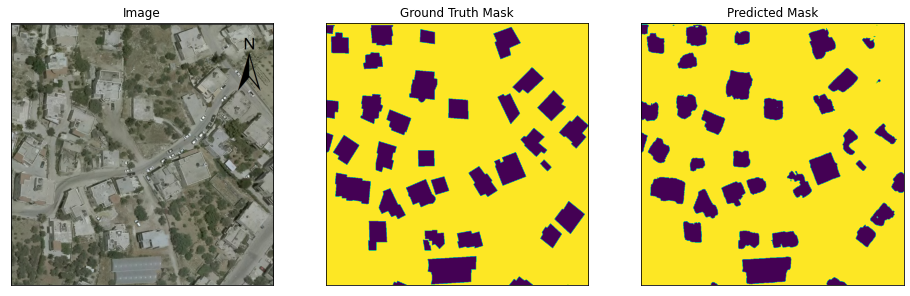

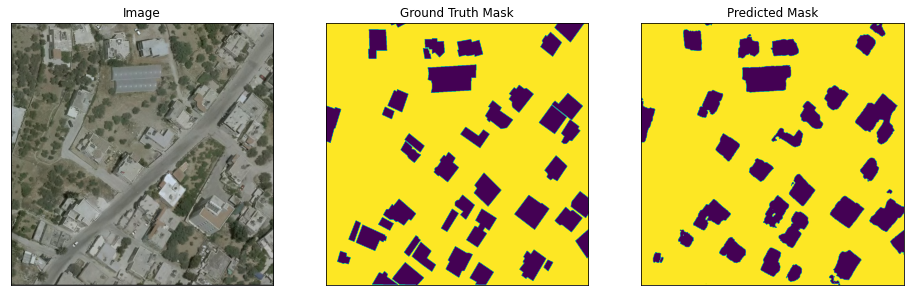

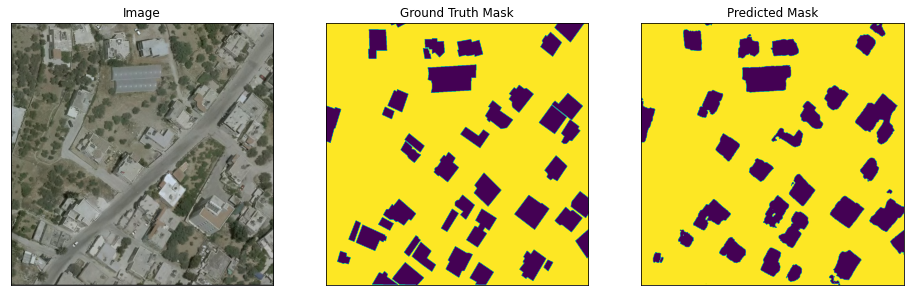

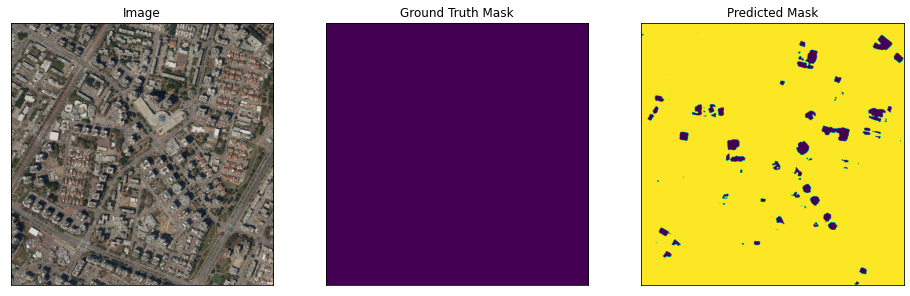

In [20]:
for i in range(len(test_dataset)):
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )